In [341]:
import pandas as pd
from pathlib import Path
import numpy as np

In [342]:
# 1 라이브러리 임포트

import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn as sk

# 알고리즘을 그래픽화 하기위한 라이브러리
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import rcParams
import re
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Rescaling
import keras

# 모델생성 라이브러리
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 데이터 스플릿,스케일링
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [343]:
DATAPATH = Path('./playground-series-s3e1/')
# N_ESTIMATORS = 100_000

train = pd.read_csv(DATAPATH/'train.csv')
test = pd.read_csv(DATAPATH/'test.csv')
sample_sub = pd.read_csv(DATAPATH/'sample_submission.csv')

In [344]:
# 쉐잎 조회
# y 값은 MedHouseVal 임 근데 숫자니까 회귀 모델임
print(train.shape)
train.head()

(37137, 10)


,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500


In [345]:
# 칼럼별 na 값 조회 이 데이터는 nan 이 없음 
train.isna().sum()

id             0
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [346]:
# 데이터 전처리1. 데이터 스플릿


x = train.drop(["MedHouseVal","id"],axis=1)
y = train["MedHouseVal"]
# print(x.shape,test.shape)
print(x.shape,y.shape)

(37137, 8) (37137,)


In [347]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,y_test = train_test_split(
    x,
    y,
    train_size=0.8,
    shuffle = True,
    # stratify = y,
    # random_state=1
)
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(29709, 8) (7428, 8)
(29709,) (7428,)


In [348]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29709 entries, 20609 to 13518
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      29709 non-null  float64
 1   HouseAge    29709 non-null  float64
 2   AveRooms    29709 non-null  float64
 3   AveBedrms   29709 non-null  float64
 4   Population  29709 non-null  float64
 5   AveOccup    29709 non-null  float64
 6   Latitude    29709 non-null  float64
 7   Longitude   29709 non-null  float64
dtypes: float64(8)
memory usage: 2.0 MB


In [349]:
# 데이터 스케일링 

scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [350]:
print(x_train.shape,y_train.shape)

(29709, 8) (29709,)


In [351]:
# 5 모델구성
# import tensorflow.keras.regularizers as reg

l = 0.0001
model = Sequential([
    Dense(256, activation='relu',input_dim=8),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation="sigmoid"),
    Rescaling(scale=5.0)
])

model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 256)               2304      
                                                                 
 dense_193 (Dense)           (None, 128)               32896     
                                                                 
 dense_194 (Dense)           (None, 64)                8256      
                                                                 
 dense_195 (Dense)           (None, 1)                 65        
                                                                 
 rescaling_16 (Rescaling)    (None, 1)                 0         
                                                                 
Total params: 43,521
Trainable params: 43,521
Non-trainable params: 0
_________________________________________________________________


In [356]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stopping = EarlyStopping(
monitor='val_loss',
mode='min',
patience=30, 
min_delta=0.0001,
verbose=1, 
)

plat =ReduceLROnPlateau(
        monitor="val_loss", 
        mode='min', 
        patience=3, 
        factor=0.1, 
        min_lr=1e-8, 
        min_delta=0.000001)

model.compile(loss="mse",optimizer="adam",metrics = ['mean_absolute_error',tf.keras.metrics.RootMeanSquaredError()])

hist = model.fit(x_train, y_train, epochs=500, 
                 validation_split=0.2,
                 batch_size=128, 
                 verbose=1,
                 callbacks = [early_stopping,plat])


Epoch 1/500
186/186 [==============================] - 1s 4ms/step - loss: 0.3911 - mean_absolute_error: 0.4450 - root_mean_squared_error: 0.6254 - val_loss: 0.3756 - val_mean_absolute_error: 0.4364 - val_root_mean_squared_error: 0.6129 - lr: 0.0010
Epoch 2/500
186/186 [==============================] - 1s 3ms/step - loss: 0.3946 - mean_absolute_error: 0.4467 - root_mean_squared_error: 0.6282 - val_loss: 0.3723 - val_mean_absolute_error: 0.4294 - val_root_mean_squared_error: 0.6102 - lr: 0.0010
Epoch 3/500
186/186 [==============================] - 1s 3ms/step - loss: 0.3880 - mean_absolute_error: 0.4426 - root_mean_squared_error: 0.6229 - val_loss: 0.3752 - val_mean_absolute_error: 0.4263 - val_root_mean_squared_error: 0.6125 - lr: 0.0010
Epoch 4/500
186/186 [==============================] - 1s 3ms/step - loss: 0.3879 - mean_absolute_error: 0.4428 - root_mean_squared_error: 0.6228 - val_loss: 0.3849 - val_mean_absolute_error: 0.4544 - val_root_mean_squared_error: 0.6204 - lr: 0.0010


In [353]:
scores = model.evaluate(x_train, y_train, batch_size=30)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


991/991 [==============================] - 1s 1ms/step - loss: 0.3687


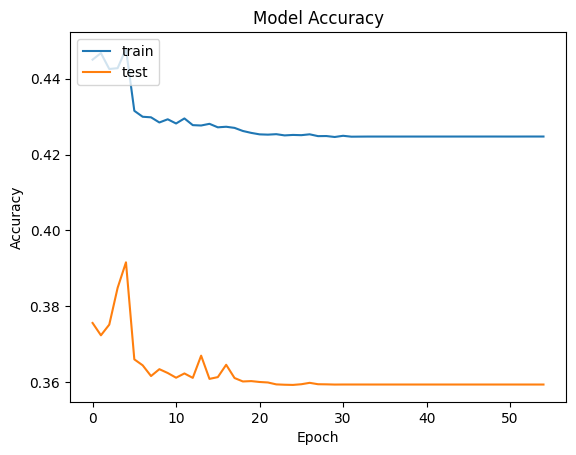

In [358]:
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['mean_absolute_error', 'val_loss'], loc='upper left')
plt.show()

In [355]:
preds =[]
test = test.drop(["id"],axis = 1)
preds.append(model.predict(test))
pred = np.average(np.array(preds),axis=0)

print(pred[:20])

# 15-3 경로와 파일명 지정
submission = pd.read_csv(DATAPATH/'sample_submission.csv',index_col="id")
# submission = pd.read_csv(DATAPATH/"sample_submission.csv",index_col="id")
submission['MedHouseVal'] = pred
submission.to_csv(DATAPATH/"submission_4.csv")


774/774 [==============================] - 1s 1ms/step
[[7.0889129e-08]
 [5.0411216e-29]
 [4.4107490e+00]
 [5.0000000e+00]
 [1.2700313e-24]
 [5.0000000e+00]
 [2.0633131e-09]
 [4.7453785e+00]
 [5.0000000e+00]
 [8.7000669e-25]
 [4.9999981e+00]
 [4.9999905e+00]
 [3.5655617e-31]
 [4.9956901e-23]
 [5.0000000e+00]
 [5.0000000e+00]
 [1.3311076e-25]
 [4.0919218e+00]
 [4.9985943e+00]
 [2.8813537e-07]]
